<a href="https://colab.research.google.com/github/vggls/medical_xai/blob/main/experiments/ham10k_resnet50/misclassified_HA_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [ ]:
pip install grad-cam

In [ ]:
import matplotlib.pyplot as plt

import torch
from torchvision  import transforms

from pytorch_grad_cam import GradCAM, HiResCAM

In [ ]:
# custom written code
from ham10k import map_images_to_paths, create_datasets, summaries
from haas import HA_image
from plot_tensor import convert_for_plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Download from Kaggle**


In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [02:30<00:00, 39.6MB/s]
100% 5.20G/5.20G [02:30<00:00, 37.0MB/s]


In [ ]:
! unzip skin-cancer-mnist-ham10000.zip

# **3. Test dataset**

In [ ]:
# to be applied to training data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          #recommended size
    transforms.RandomHorizontalFlip(),      #data augmentation
    transforms.RandomVerticalFlip(),        #data augmentation
    transforms.RandomRotation(degrees=20),  #data augmentation
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])
# to be applied to validation and test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [ ]:
dataframe = map_images_to_paths()

In [ ]:
train_dataset, validation_dataset, test_dataset= create_datasets(dataframe = dataframe,
                                                                 train_transforms = train_transforms,
                                                                 test_transforms = test_transforms)

In [ ]:
classes = {'akiec': 'Actinic Keratoses (akiec)',
           'bcc': 'Basal Cell Carcinoma (bcc)',
           'bkl': 'Benign Keratosis-like Lesions (bkl)',
           'df': 'Dermatofibroma (df)',
           'nv': 'Melanocytic Nevi (nv)',
           'vasc': 'Pyogenic Granulomas and Hemorrhage (vasc)',
           'mel': 'Melanoma (mel)'}

In [ ]:
test_dataset.class_to_idx

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

# **4. ResNet50 - HA images**

In [ ]:
model_path = './drive/MyDrive/Colab_Notebooks/dataset_models/HAM10000/Models/'
resnet50 = torch.load(model_path + 'ham10k_resnet50.pt')
resnet50 = resnet50.eval()

In [ ]:
gradcam_instance = GradCAM(model=resnet50, target_layers=[resnet50.layer4[2].conv3], use_cuda=True)
hirescam_instance = HiResCAM(model=resnet50, target_layers=[resnet50.layer4[2].conv3], use_cuda=True)

In [ ]:
unfreeze = [resnet50.conv1, resnet50.bn1, resnet50.layer1, resnet50.layer2, resnet50.layer3, resnet50.layer4]
for child in unfreeze:
    for param in child.parameters():
        param.requires_grad = True

In [ ]:
#@title function

def ham_misclassified_ha_images(class_label, num_examples):

  i = 0
  for tensor,label in test_dataset:
    tensor = tensor.cuda()

    if (label==class_label and label == int(torch.argmax(resnet50(tensor.unsqueeze(0))))):

      plt.figure()
      fig, ax = plt.subplots(1, 5, figsize=(15,3))

      ax[0].imshow(convert_for_plot(tensor))
      ax[0].set_title('pred: {}'.format( list(test_dataset.class_to_idx.keys())[label])); ax[0].axis('off')

      gradcam_attributions = gradcam_instance(tensor.unsqueeze(0))[0,:,:]
      hirescam_attributions = hirescam_instance(tensor.unsqueeze(0))[0,:,:]

      ha_gradcam_tensor = HA_image(tensor, gradcam_attributions)
      ha_hirescam_tensor = HA_image(tensor, hirescam_attributions)

      gradcam_pred = int(torch.argmax(resnet50(ha_gradcam_tensor.unsqueeze(0))))
      hirescam_pred = int(torch.argmax(resnet50(ha_hirescam_tensor.unsqueeze(0))))

      if (label != gradcam_pred) and (label != hirescam_pred):

        i+=1

        gradcam_class = list(test_dataset.class_to_idx.keys())[gradcam_pred]
        hirescam_class = list(test_dataset.class_to_idx.keys())[hirescam_pred]

        ax[1].imshow(gradcam_attributions); ax[1].set_title('Grad-CAM Attributions'); ax[1].axis('off')

        ax[2].imshow(convert_for_plot(ha_gradcam_tensor)); ax[2].set_title('Grad-CAM HA image \n pred: {}'.format(gradcam_class)); ax[2].axis('off')

        ax[3].imshow(hirescam_attributions); ax[3].set_title('HiResCAM Attributions'); ax[3].axis('off')

        ax[4].imshow(convert_for_plot(ha_hirescam_tensor)); ax[4].set_title('HiResCAM HA image \n pred: {}'.format(hirescam_class)); ax[4].axis('off')

      else:
        plt.close(fig)

      if i==num_examples:
        break

<ipython-input-16-61574df67180>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 5, figsize=(15,3))


<Figure size 640x480 with 0 Axes>

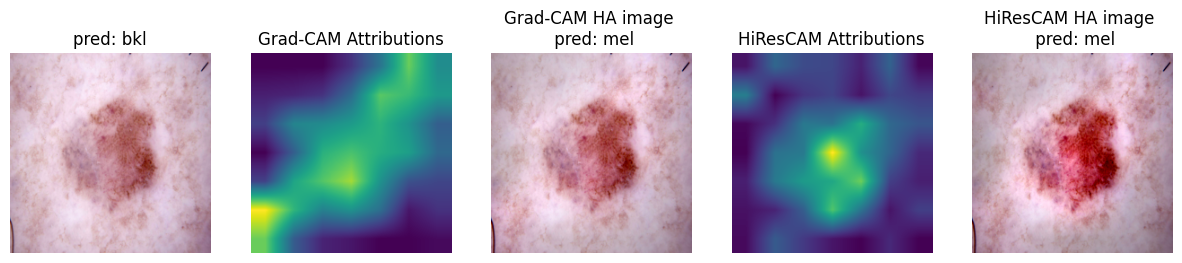

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

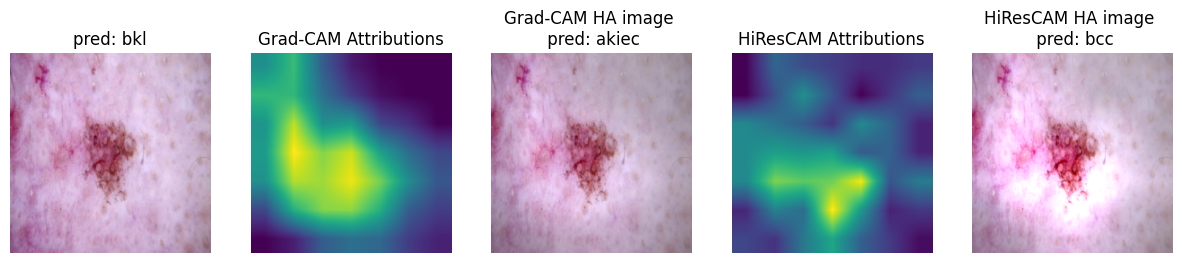

<Figure size 640x480 with 0 Axes>

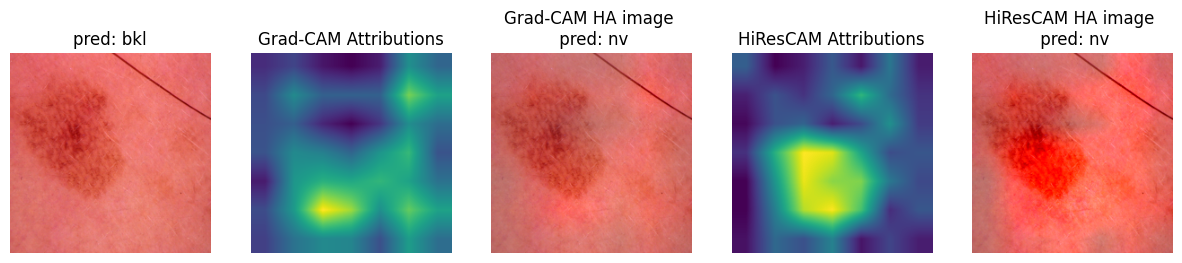

<Figure size 640x480 with 0 Axes>

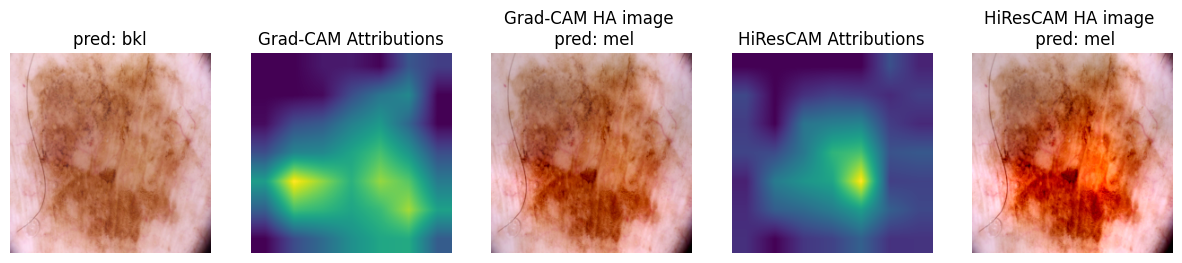

<Figure size 640x480 with 0 Axes>

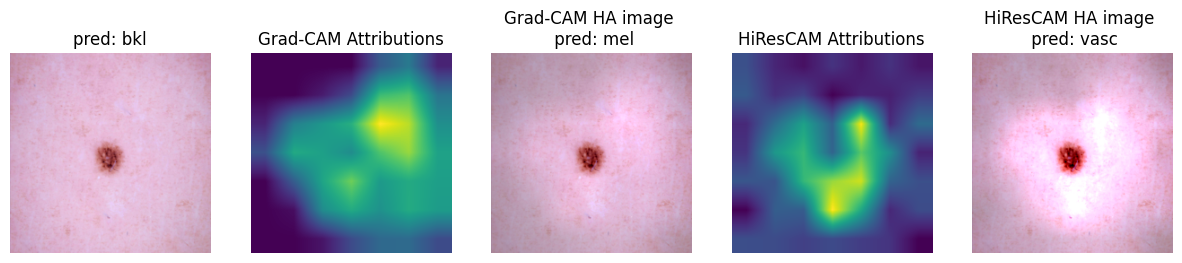

<Figure size 640x480 with 0 Axes>

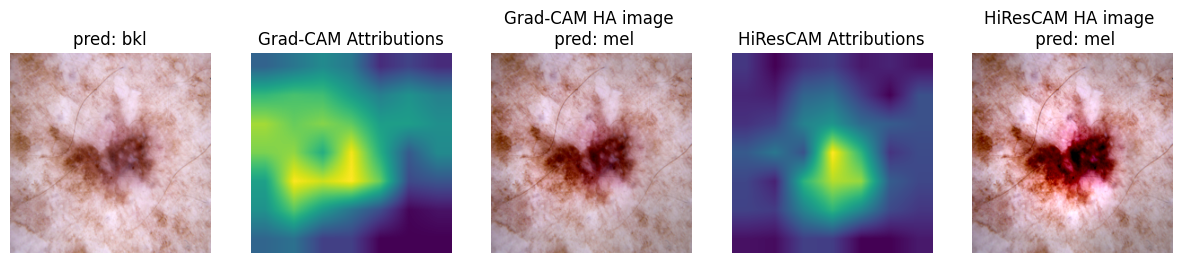

<Figure size 640x480 with 0 Axes>

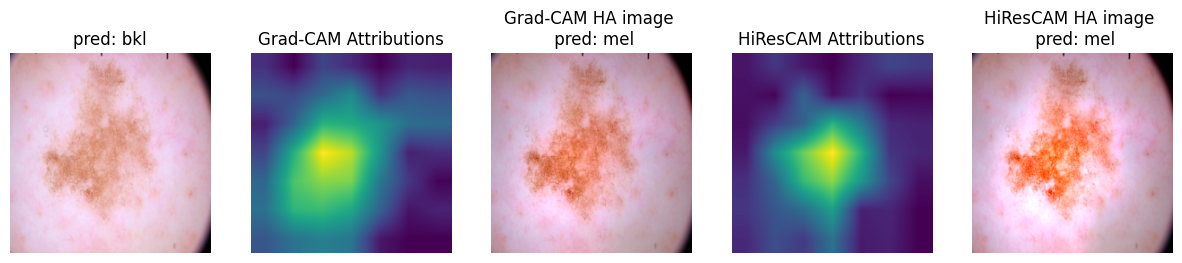

<Figure size 640x480 with 0 Axes>

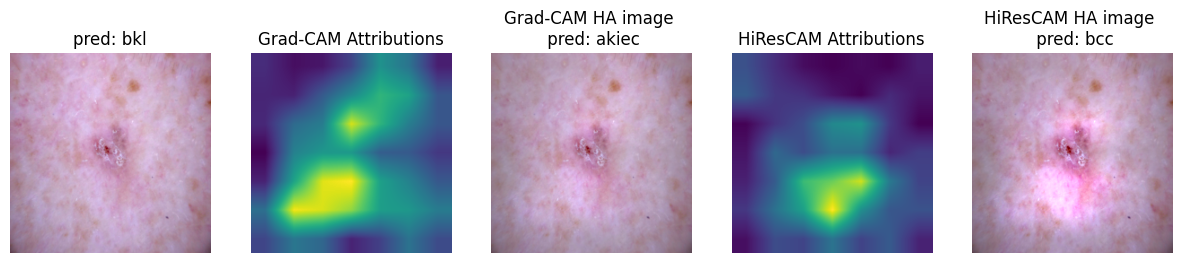

<Figure size 640x480 with 0 Axes>

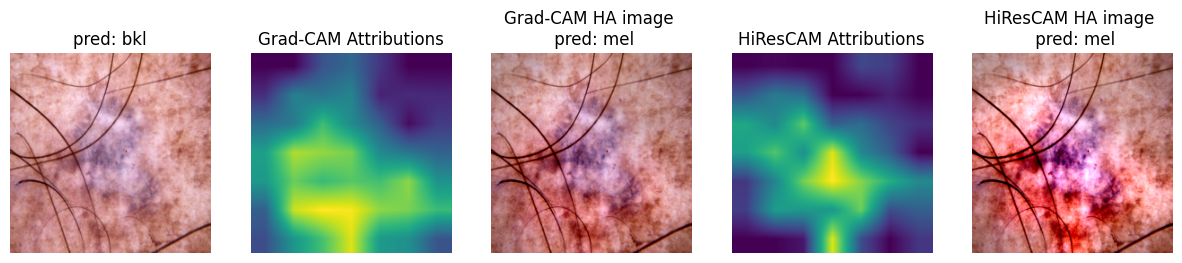

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

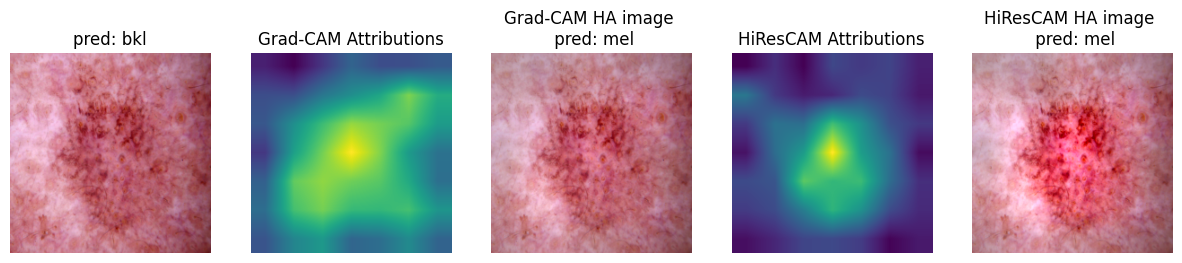

In [ ]:
ham_misclassified_ha_images(2,10)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

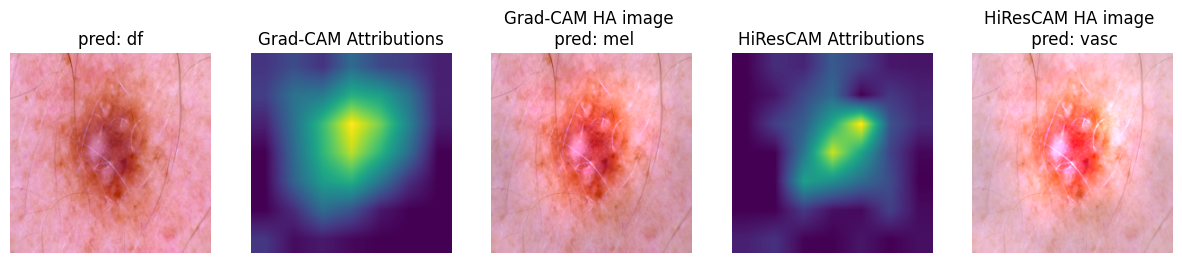

<Figure size 640x480 with 0 Axes>

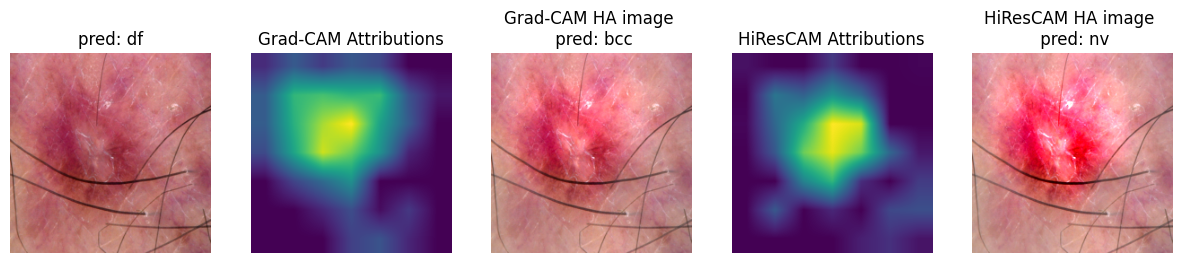

<Figure size 640x480 with 0 Axes>

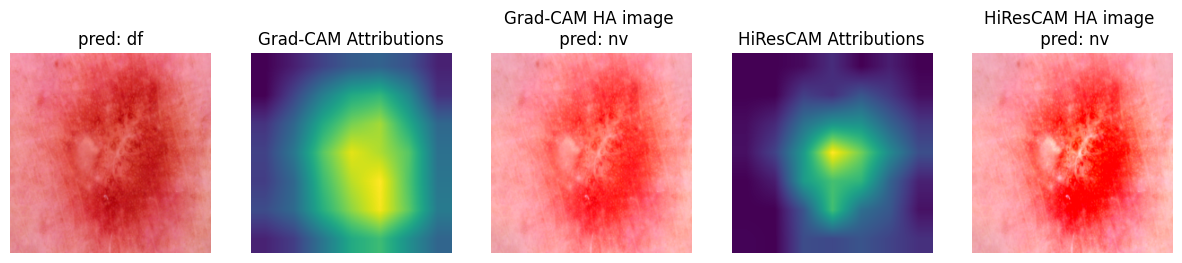

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

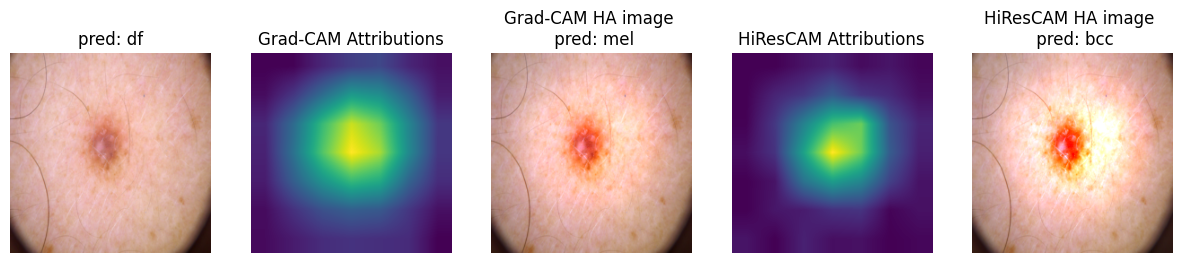

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
ham_misclassified_ha_images(3,10)